# Long short term memory

We previously explored RNNs, neural networks that are able to propagate some hidden state through a rolled out version of itself. A major problem with RNNs is exploding or vanishing gradients. Gradient clipping solves the exploding gradient problem, but the vanishing gradient problem is harder to solve. LSTMs propose a different architecture which benefits from a hidden state like RNNs, but mitigates the vanishing gradient problem. Another issue RNNs have is that the hidden state often forgets information from a while ago in the sequence and is more biased towards more recent tokens. LSTMs also address this issue with their gated structure. 


In [1]:
from torch import nn
import torch 
import numpy as np
import pandas as pd
from torch.nn.utils.rnn import PackedSequence
import torch.nn.functional
from torch.utils.data import random_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import AG_NEWS
from torch import nn
from torch.utils.data import DataLoader
import math
from torch.nn.utils.rnn import pad_sequence

## LSTM model defintion
The goal here is to build a substitute for the torch.nn.rnn.lstm module. This should be able to handle packed sequences and batched data the same way the source code for that module does. For now, does not need to have multiple layers or be bidirectional.

In [2]:
class LSTMCell(nn.Module): 


    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.x2h = nn.Linear(input_size, 4 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size, bias=bias)
        self.reset_parameters()



    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)
    
    def forward(self, x, hidden, cell_state):

        #pdb.set_trace()
        hx = hidden
        
        x = x.view(-1, x.size(1))
        
        gates = self.x2h(x) + self.h2h(hx)
    
        gates = gates.squeeze()
        
        i_gate, f_gate, c_gate, o_gate = gates.chunk(4, 1)
        
        in_gate = torch.sigmoid(i_gate)
        forget_gate = torch.sigmoid(f_gate)
        g_t = torch.tanh(c_gate)
        cell_state_clone = cell_state.clone()
        cell_gate = torch.mul(forget_gate, cell_state_clone) + torch.mul(in_gate, g_t)

        out_gate = torch.sigmoid(o_gate)
        

        hm = out_gate * nn.functional.tanh(cell_gate)
        return (hm, cell_gate)

In [440]:
class lstm(nn.Module): 
    def __init__(self, input_size, hidden_dim, num_layers=1, output_dim=1) -> None:
        super().__init__()
        self.input_dim = input_size
        self.hidden_dim  = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim
        
        self.lstm_cell_list = nn.ModuleList()
        for _ in range(self.num_layers): 
            self.lstm_cell_list.append(LSTMCell(self.input_dim, self.hidden_dim))
        
        self.fc = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, x, h_in=None, c_in=None):

        if isinstance(x, PackedSequence):
            input, batch_sizes, sorted_indices, unsorted_indices = x
            max_batch_size = batch_sizes[0]
            if h_in is None: 
                h_in = self.init_h(max_batch_size, x)
                c_in = self.init_h(max_batch_size, x)
        
            data_offset = 0
            outputs = []
            for batch_size in batch_sizes:
                current_input = input[data_offset:data_offset + batch_size]
                data_offset += batch_size
                current_input = current_input.unsqueeze(0)
                if batch_size < max_batch_size: 
                    h_in[:,batch_size:,:] = 0
                    c_in[:,batch_size:,:] = 0
                    pad_size = max_batch_size - batch_size
                    # Create a tensor of zeros with the padding size
                    padding = torch.zeros(1, pad_size, self.hidden_dim, device=current_input.device)
                    # Concatenate the padding to the current input
                    current_input = torch.cat([current_input, padding], dim=1)
                
                combined = torch.cat([current_input, h_in], dim=2)
                
                i_gate_output = self.input_gate(combined)
                i_node_output = self.input_node(combined)
                o_gate_output = self.output_gate(combined)
                f_gate_output = self.forget_gate(combined)

                c_out = (f_gate_output * c_in) + (i_node_output * i_gate_output)

                h_out = self.tanh(c_out) * o_gate_output
                out = self.output_layer(h_out)
                h_in = h_out
                c_in = c_out
                outputs.append(out)

                # Handle decreasing batch siz
            output_packed = PackedSequence(outputs, batch_sizes, sorted_indices, unsorted_indices)
            return output_packed, (h_out, c_out)
        
        else:
            if h_in is None: 
                h_in = self.init_h(x.size(0)).to(x.device)
                c_in = self.init_h(x.size(0)).to(x.device)
            h_tmp = h_in.clone()
            c_tmp = c_in.clone()
            for t in range(x.size(1)):
                for layer in range(self.num_layers): 
                    input = x[:,t,:]
                    if layer == 0: 
                        (h_out, c_out) = self.lstm_cell_list[layer](input, h_in[layer], c_in[layer])  # if first hidden layer, use input
                    else: 
                        (h_out, c_out) = self.lstm_cell_list[layer](h_in[layer - 1], h_in[layer], c_in[layer])  # else, use previous hidden layer as input 
                    h_tmp[layer] = h_out
                    c_tmp[layer] = c_out
            
        return h_out, c_out
    
    
    def init_h(self, batch_size):
        #zero initialization 
        #alternatives include but not limited to Xavier/Kaiminh initialization
        return torch.zeros(self.num_layers, batch_size, self.hidden_dim, requires_grad=False)

In [4]:
class lstm_simplified(nn.Module): 
    def __init__(self, input_size, hidden_dim, output_dim=1) -> None:
        super().__init__()
        self.input_dim = input_size
        self.hidden_dim  = hidden_dim
        
        self.x_h = nn.Sequential(
            nn.Linear(input_size, hidden_dim * 4),
        )
        self.h_x = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
        )

        self.tanh = nn.Tanh()

        # this output layer can be fancier if needed by the use case
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h_in=None, c_in=None):

        if isinstance(x, PackedSequence):
            input, batch_sizes, sorted_indices, unsorted_indices = x
            max_batch_size = batch_sizes[0]
            if h_in is None: 
                h_in = self.init_h(max_batch_size, x)
                c_in = self.init_h(max_batch_size, x)
        
            data_offset = 0
            outputs = []
            for batch_size in batch_sizes:
                current_input = input[data_offset:data_offset + batch_size]
                data_offset += batch_size
                current_input = current_input.unsqueeze(0)
                if batch_size < max_batch_size: 
                    h_in[:,batch_size:,:] = 0
                    c_in[:,batch_size:,:] = 0
                    pad_size = max_batch_size - batch_size
                    # Create a tensor of zeros with the padding size
                    padding = torch.zeros(1, pad_size, self.hidden_dim, device=current_input.device)
                    # Concatenate the padding to the current input
                    current_input = torch.cat([current_input, padding], dim=1)
                
                gates = self.x_h(current_input) +  self.h_x(h_in)
                input_gate, forget_gate, input_node, output_gate = gates.chunk(4, 2)
                i_gate_output = torch.sigmoid(input_gate)
                i_node_output = torch.tanh(input_node)
                o_gate_output = torch.sigmoid(output_gate)
                f_gate_output = torch.sigmoid(forget_gate)
                
                c_out = (f_gate_output * c_in) + (i_node_output * i_gate_output)

                h_out = self.tanh(c_out) * o_gate_output
                out = self.output_layer(h_out)
                h_in = h_out
                c_in = c_out
                outputs.append(out)

                # Handle decreasing batch siz


            output_packed = PackedSequence(outputs, batch_sizes, sorted_indices, unsorted_indices)
            return output_packed, h_out, c_out
        
        else:
            
            for t in range(x.size(1)):
                input = x[:,t,:]
                gates = self.x_h(input) +  self.h_x(h_in)
                input_gate, forget_gate, input_node, output_gate = gates.chunk(4, 1)
                i_gate_output = torch.sigmoid(input_gate)
                i_node_output = torch.tanh(input_node)
                o_gate_output = torch.sigmoid(output_gate)
                f_gate_output = torch.sigmoid(forget_gate)
                
                c_out = (f_gate_output * c_in) + (i_node_output * i_gate_output)

                h_out = self.tanh(c_out) * o_gate_output
                out = self.output_layer(h_out)
                h_in = h_out
                c_in = c_out
            
        return out, (h_out, c_out)
        
    
    
    def init_h(self, batch_size, sequence_length):
        #zero initialization 
        #alternatives include but not limited to Xavier/Kaiminh initialization
        return torch.zeros(batch_size, self.hidden_dim, requires_grad=False)

In [5]:
class newsLSTM(nn.Module): 
    def __init__(self, vocab_size, embed_size, hidden_size) -> None:
        super(newsLSTM, self).__init__()
        
        self.encoder = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.hidden_size = hidden_size 
        self.lstm = nn.LSTM(embed_size, 
                           hidden_size,
                           batch_first=True)
        
        self.hidden2label = nn.Linear(hidden_size, 4)
        self.dropoutLayer = nn.Dropout(p=0.5)


    def forward(self, x, x_len):
        embedded = self.encoder(x)
        x_packed = nn.utils.rnn.pack_padded_sequence(embedded, x_len, batch_first=True, enforce_sorted=False)
        output, (h_t, c_t) = self.lstm(x_packed)  # Pass the initial hidden state 'h' to the RNN   
        # hidden = self.dropout(torch.cat((h_t[-2,:,:], h_t[-1,:,:]), dim=1))     
        hidden = self.dropoutLayer(h_t.squeeze())
        
        # Linear layer and softmax
        label_space = self.hidden2label(hidden)
        
        return label_space
    

We repeat the exact same news classification task performed by in the bidirectionalRNN subdir

In [6]:
train_iter = AG_NEWS(split='train')

# Convert to list to enable random splitting
train_dataset = list(train_iter)

#80-20 train-val split 
train_size = int(len(train_dataset) * 0.8)  
val_size = len(train_dataset) - train_size  
train_data, val_data = random_split(train_dataset, [train_size, val_size])

tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

VOCAB_SIZE = 5000

# Build vocab based on the train_data
train_data_iter = (text for _, text in train_data)
vocab = build_vocab_from_iterator(yield_tokens(train_data_iter), specials=["<unk>"], max_tokens=VOCAB_SIZE)
vocab.set_default_index(vocab["<unk>"])

In [7]:
train_data[0]

(2,
 'The mother of all sponsorships Emirates Airline and Arsenal Football Club have signed the biggest club sponsorship in football history, collectively worth about 100 million (Rs 816.')

In [8]:
vocab(['word', 'probably', 'unknown', 'gibberish'])

[2084, 1612, 0, 0]

In [9]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [10]:
vocab.lookup_tokens([4999])

['bat']

In [11]:
def collate_batch(batch):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    label_list, text_list, lengths = [], [], []
    
    # Sort the batch in the descending order
    batch.sort(key=lambda x: len(x[1]), reverse=True)
    
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        lengths.append(processed_text.size(0))
        
    label_list = torch.tensor(label_list, dtype=torch.int64)
    lengths = torch.tensor(lengths, dtype=torch.int64)
    
    # Pad sequences
    text_list = pad_sequence(text_list, batch_first=True)
    
    return label_list.to(device), text_list.to(device), lengths

In [12]:
train_loader = DataLoader(train_data, batch_size = 8, shuffle = True, collate_fn = collate_batch)
val_loader = DataLoader(val_data, batch_size = 8, shuffle = False, collate_fn = collate_batch)

In [13]:
batch = next(iter(train_loader))

# Inspect the shape of the input data
input_data = batch[1]  # Assuming the input data is the first element of the batch
input_shape = input_data.shape[0]

In [14]:
batch[1].shape

torch.Size([8, 69])

In [15]:
len(batch)

3

In [16]:
a =  torch.ones(5, 50)
a =  torch.ones(5, 50)
a =  torch.ones(5, 50)

In [17]:
m = nn.Softmax(dim=1)
input = torch.randn(2, 3)
output = m(input)

In [18]:
input

tensor([[-0.2368, -0.4824,  0.1967],
        [ 3.1247,  0.0103, -1.3040]])

In [19]:
output

tensor([[0.3008, 0.2353, 0.4640],
        [0.9467, 0.0420, 0.0113]])

In [20]:
input_shape

8

In [21]:
print(batch[0])
print(batch[1].shape)

tensor([0, 1, 1, 1, 0, 2, 0, 3], device='cuda:0')
torch.Size([8, 69])


In [22]:
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
NUM_EPOCHS = 10
DROPOUT = 0.5
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

EMBEDDING_DIM = 128
BIDIRECTIONAL = True
HIDDEN_DIM = 128
NUM_LAYERS = 2
OUTPUT_DIM = 4

In [23]:
model = newsLSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

/home/aryaman.pandya/ml_accel/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
def train(model, train_loader, val_loader, loss_function, optim, epochs, device):
    
    for epoch in range(epochs):
        losses = [] #group losses for loss visualization 
        running_loss = 0.0
        model.train()
        print("Epoch %d / %d" % (epoch+1, epochs))
        print("-"*10)
    
        for i, batch_data in enumerate(train_loader):
            
            model.train()
            (y, x, x_size) = batch_data
            y_pred = model(x, x_size.cpu())
            #print(f"y_pred: {y_pred}, y_target: {y}")
            loss = loss_function(y_pred, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            running_loss += loss.item()
            losses.append(loss)
            
        model.eval()
        val_loss = 0.0
        print("Epoch: {}, train loss: {:.4f}".format(epoch+1, running_loss/len(losses)))
        with torch.no_grad():
            for i, batch_data in enumerate(val_loader):
                (y, x, x_size) = batch_data
                y, x, x_size = y.to(device), x.to(device), x_size.to(device)
                
                y_pred = model(x, x_size.cpu())
                loss = loss_function(y_pred, y)
                
                val_loss += loss.item()
        
        print("Epoch: {}, validation loss: {:.4f}".format(epoch+1, val_loss/len(val_loader)))

In [25]:
train(model, train_loader, val_loader, torch.nn.functional.cross_entropy, optimizer, NUM_EPOCHS, DEVICE)

Epoch 1 / 10
----------


KeyboardInterrupt: 

# Notes: 

Something about the handling of decreasing batch sizes and packed sequences makes our lstm from scratch inefficient at learning when compared to the native torch version. However, working through the implementation and the bugs that came with it helped me better understand the internals of the lstm. What's especially impressive is that using a single layered unidirectional LSTM is much more effective for learning on this task than a 2 layered bidirectional RNN (see `RecurrentNetworks/bidirectionalRNN`)

Below, we still make use of our hand crafted LSTM for a non batched, non-packed use case where it should not suffer from its inefficiencies.

In [26]:
nn.LSTM()

TypeError: __init__() missing 2 required positional arguments: 'input_size' and 'hidden_size'

In [441]:
class stockLSTM(nn.Module): 
    def __init__(self, input_dim, hidden_size, output_dim) -> None:
        super(stockLSTM, self).__init__()
        
        self.hidden_size = hidden_size 
        self.lstm = lstm(input_dim, hidden_size)
        self.output_dim = output_dim
        self.output_layer = nn.Sequential(nn.Linear(hidden_size, output_dim))


    def forward(self, x):
        h, _ = self.lstm(x)
        output = self.output_layer(h.squeeze())
        
        return output
    

In [442]:
def train_scratch_model(model, train_loader, val_loader,  loss_function, optim, epochs, device, scheduler, start_decay):
    
    losses = [] #group losses for loss visualization 
    
    for epoch in range(epochs):
        running_loss = 0 
        print("Epoch %d / %d" % (epoch+1, epochs))
        print("-"*10)
        if (epoch > start_decay): 
            scheduler.step()
        
        model.train()
        for i, (x, y) in enumerate(train_loader):
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            # print(f"y shape: {y.shape}, y_pred shape: {y_pred.shape}")
            loss = loss_function(y_pred, y) 
            running_loss+=loss.item()
            optim.zero_grad()
            loss.backward() #backprop 
            optim.step() #update weights
  
        losses.append((running_loss / i))
        print("Step: {}/{}, current Epoch loss: {:.4f}".format(i, len(train_loader), (running_loss / i)))

        val_loss = 0
        with torch.no_grad():
            for i, (x,y) in enumerate(val_loader):
                y, x,  = y.to(device), x.to(device) 
                
                y_pred = model(x)
                loss = loss_function(y_pred, y)
                
                val_loss += loss.item()
        
        print("Epoch: {}, validation loss: {:.4f}".format(epoch+1, val_loss/len(val_loader)))
        
    return losses

In [443]:
def load_data(stock, sequence_length):
    # Convert pandas dataframe to numpy array
    data_raw = stock.to_numpy()

    data = []

    # Loop over the stock data to generate sequences of 'sequence_length' consecutive data points
    # This is done because RNNs learn to predict data in a sequence from past sequence
    for index in range(len(data_raw) - sequence_length):
        data.append(data_raw[index: index + sequence_length])

    data = np.array(data)
    set_size = int(data.shape[0])

    # Generate the train data
    # x_train is all sequences excluding the last data point from each sequence
    x = data[:,:-1,:]
    # y_train is the last data point from each sequence
    y = data[:,-1,:]
    

    # Return the train and test data
    return [x, y]

In [444]:
ibm_df = pd.read_csv('IBM.csv')
ibm_df['Date'] = pd.to_datetime(ibm_df['Date'])
ibm_df.set_index('Date',inplace=True)
ibm_df = ibm_df[['Close']]
ibm_df["Close"] = (ibm_df["Close"]-ibm_df["Close"].mean())/ibm_df["Close"].std()

# Get the number of rows in the DataFrame
num_rows = ibm_df.shape[0]

# Compute the split point
split_point = int(num_rows*0.8)

# Split the DataFrame
train_val_df = ibm_df.iloc[:split_point]
test_df = ibm_df.iloc[split_point:]
val_split = int((train_val_df.shape[0])*0.8)
train_df = train_val_df.iloc[:val_split]
val_df = train_val_df[val_split:]

x_train, y_train = load_data(train_df, 10) 
x_test, y_test = load_data(test_df, 10) 
x_val, y_val = load_data(val_df, 10)

In [445]:
print(train_df.head()) #to ensure no shuffling accidentally occurred 

               Close
Date                
2006-01-03 -1.693534
2006-01-04 -1.696465
2006-01-05 -1.681809
2006-01-06 -1.616527
2006-01-09 -1.649035


In [446]:
print(test_df.tail())

               Close
Date                
2017-12-22  0.183396
2017-12-26  0.192189
2017-12-27  0.200182
2017-12-28  0.224430
2017-12-29  0.207910


In [447]:
print("Train input data shape: {}, target shape: {}".format(x_train.shape, y_train.shape)) 

Train input data shape: (1922, 9, 1), target shape: (1922, 1)


In [448]:
print("Test input data shape: {}, target shape: {}".format(x_test.shape, y_test.shape)) 

Test input data shape: (594, 9, 1), target shape: (594, 1)


In [449]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
x_val = torch.from_numpy(x_val).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)
y_val = torch.from_numpy(y_val).type(torch.Tensor)

In [450]:
train_set = torch.utils.data.TensorDataset(x_train,y_train)
test_set = torch.utils.data.TensorDataset(x_test,y_test)
val_set = torch.utils.data.TensorDataset(x_val,y_val)

In [451]:
NUM_EPOCHS = 200
BATCH_SIZE = 32 
LEARNING_RATE = 0.01
INPUT_DIM = 1 
OUTPUT_DIM = 1 
HIDDEN_DIM = 16 

In [452]:
train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_set, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset=val_set, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=False)

In [453]:
model = stockLSTM(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)

In [454]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
DECAY_FACTOR = 0.0002
DECAY_EPOCHS = 100
START_DECAY_EPOCH = 100
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=DECAY_EPOCHS, gamma=DECAY_FACTOR)

In [455]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [456]:
model = model.to(device)

In [457]:
losses = train_scratch_model(model=model, train_loader=train_loader, val_loader=val_loader, loss_function=torch.nn.MSELoss(size_average=True), optim=optimizer, epochs=NUM_EPOCHS, device=device, scheduler=scheduler, \
    start_decay=START_DECAY_EPOCH)

Epoch 1 / 200
----------


/home/aryaman.pandya/ml_accel/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning:

size_average and reduce args will be deprecated, please use reduction='mean' instead.



ValueError: too many values to unpack (expected 2)

# Notes 
After increasing the learning rate and de-coupling the output layer from the original lstm neural network we see performance boosts that get the LSTM to actually learn. The RNN still seems to outperform the LSTM on this task, but such short window inputs are not where LSTMs thrive. They thrive when they can capture long term dependencies that RNNs cannot. We will be exploring this idea further in the future. 

We also don't want an overfitted model and are trying to detect a complex pattern from a simplified input sequence. Considering this, the network performs pretty well

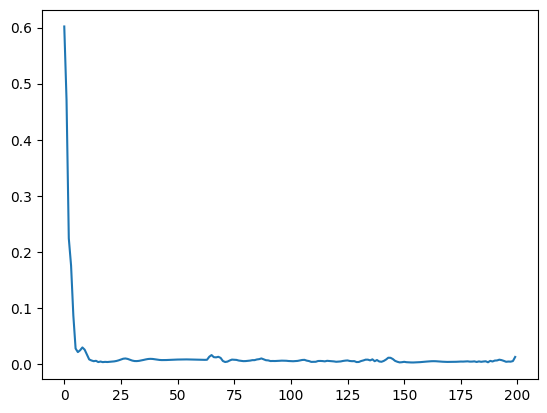

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

In [ ]:
import plotly.graph_objects as go
epochs = list(range(len(losses)))

fig = go.Figure(data=go.Scatter(x=epochs, y=losses, mode='lines+markers', name='Train'))

fig.update_layout(title='Training Loss per Epoch',
                   xaxis_title='Epoch',
                   yaxis_title='Loss')

fig.show()

## Evaluation

In [ ]:
targets = [] 
predicted = []

model.eval()
for i, (x, y) in enumerate(test_loader):
        
    x = x.to(device)
    y = y.to(device)
    y_pred = model(x)
    predicted.append(y_pred.cpu().detach().numpy())
    targets.append(y.cpu().detach().numpy())
    

In [ ]:
from sklearn.metrics import mean_squared_error
target_long_array = np.concatenate(targets)
predicted_long_array = np.concatenate(predicted)

mse = mean_squared_error(target_long_array, predicted_long_array)
print(f'Mean Squared Error (MSE): {mse}')
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Squared Error (MSE): 0.003431388409808278
Root Mean Squared Error (RMSE): 0.05857805535197258


In [ ]:
target_list = target_long_array.tolist()
predicted_list = predicted_long_array.tolist()

In [ ]:
import plotly.graph_objects as go
epochs = list(range(len(losses)))
predicted_list = [i[0] for i in predicted_list]
x = [i for i in range(len(predicted_list))]
fig = go.Figure(data=go.Scatter(x=x, y=predicted_list, mode='lines+markers', name='Train'))

fig.update_layout(title='Training Loss per Epoch',
                   xaxis_title='Epoch',
                   yaxis_title='Loss')

fig.show()

In [ ]:
print(len(predicted_list))

594


In [ ]:
print(predicted_list)

[0.2065519094467163, 0.0683530867099762, -0.09927207231521606, -0.14396196603775024, 0.0875411331653595, 0.11380940675735474, 0.08433964848518372, 0.08545875549316406, -0.10493555665016174, 0.015919864177703857, 0.06017252802848816, -0.05012178421020508, 0.0860741138458252, -0.012329816818237305, 0.0449238121509552, 0.0767393708229065, 0.013767421245574951, 0.08691132068634033, 0.10730957984924316, 0.09508872032165527, -0.037263453006744385, 0.057047367095947266, -0.03065308928489685, -0.041702985763549805, -0.013275623321533203, 0.018553584814071655, -0.08835524320602417, -0.07350397109985352, 0.00772857666015625, -0.04533848166465759, -0.005342662334442139, 0.13420040905475616, 0.11811190843582153, 0.16374440491199493, 0.23288483917713165, 0.22725869715213776, 0.17711852490901947, 0.12781661748886108, 0.15516074001789093, 0.15245448052883148, 0.16342118382453918, 0.11297851800918579, -0.20254456996917725, -0.11959207057952881, -0.011026918888092041, -0.004140496253967285, -0.04232323

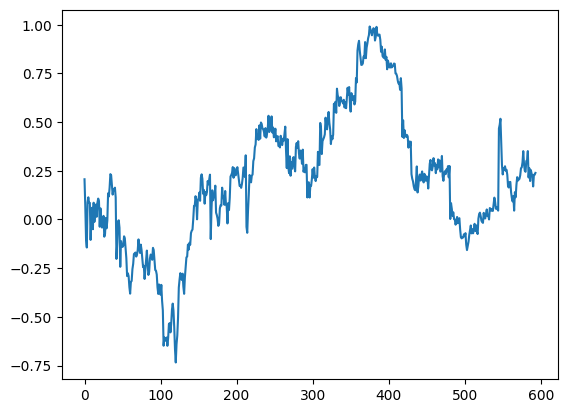

In [ ]:
plt.plot(predicted_list)
plt.show()

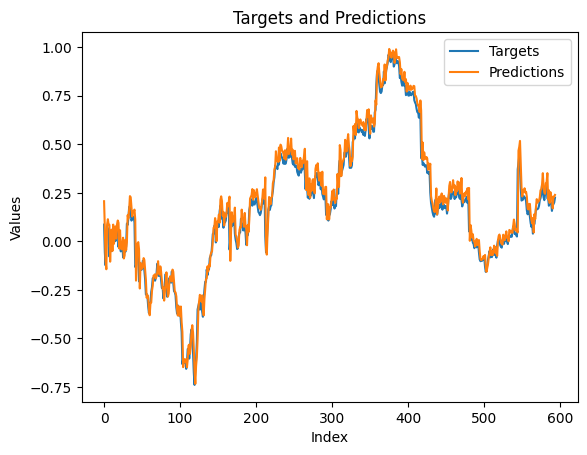

In [ ]:
fig, ax = plt.subplots()

# Add the targets and predictions to the plot
ax.plot(target_list, label='Targets')
ax.plot(predicted_list, label='Predictions')

# Add labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Values')
ax.set_title('Targets and Predictions')

# Add a legend
ax.legend()

# Show the plot
plt.show()